# Titanic: WCG + XGBoost - Python Conversion

In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeRegressor
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier

RANDOM_STATE = 300

## Load Data

In [17]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')

# Perishedカラムが存在する場合、Survivedに変換
if "Perished" in train.columns and "Survived" not in train.columns:
    train["Survived"] = 1 - train["Perished"]

test['Survived'] = np.nan
data = pd.concat([train, test], ignore_index=True)

## Engineer Person Type (Title)

In [18]:
def make_title(name, sex):
    if isinstance(name, str) and 'Master' in name:
        return 'boy'
    if sex == 'female':
        return 'woman'
    return 'man'

data['Title'] = [make_title(n, s) for n, s in zip(data['Name'], data['Sex'])]

## Impute Missing Age and Fare

In [ ]:
def impute_by_tree(df, target_col, feature_cols):
    X = df[feature_cols]
    y = df[target_col]
    
    cat_cols = [c for c in feature_cols if df[c].dtype == 'object']
    num_cols = [c for c in feature_cols if df[c].dtype != 'object']
    
    pre = ColumnTransformer(
        transformers=[
            ('cat', OneHotEncoder(handle_unknown='ignore'), cat_cols),
            ('num', 'passthrough', num_cols),
        ]
    )
    pipe = Pipeline(
        steps=[
            ('pre', pre),
            ('reg', DecisionTreeRegressor(random_state=RANDOM_STATE, max_depth=6)),
        ]
    )
    
    mask = ~y.isna()
    pipe.fit(X[mask], y[mask])
    
    y_pred = pipe.predict(X[~mask])
    df.loc[~mask, target_col] = y_pred

# Impute Age
impute_by_tree(
    data,
    target_col='Age',
    feature_cols=['Title', 'Pclass', 'SibSp', 'Parch']
)

# Impute Embarked
data['Embarked'] = data['Embarked'].fillna(data['Embarked'].mode().iloc[0])

# Impute Fare
impute_by_tree(
    data,
    target_col='Fare',
    feature_cols=['Title', 'Pclass', 'Embarked', 'Sex', 'Age']
)

## Engineer Features

In [20]:
data['TicketFreq'] = data.groupby('Ticket')['Ticket'].transform('count')
data['FamilySize'] = data['SibSp'] + data['Parch'] + 1
data['FareAdj'] = data['Fare'] / data['TicketFreq']

data['x1'] = data['Fare'] / (data['TicketFreq'] * 10.0)
data['x2'] = data['FamilySize'] + (data['Age'] / 70.0)

## Visualize Engineered Features

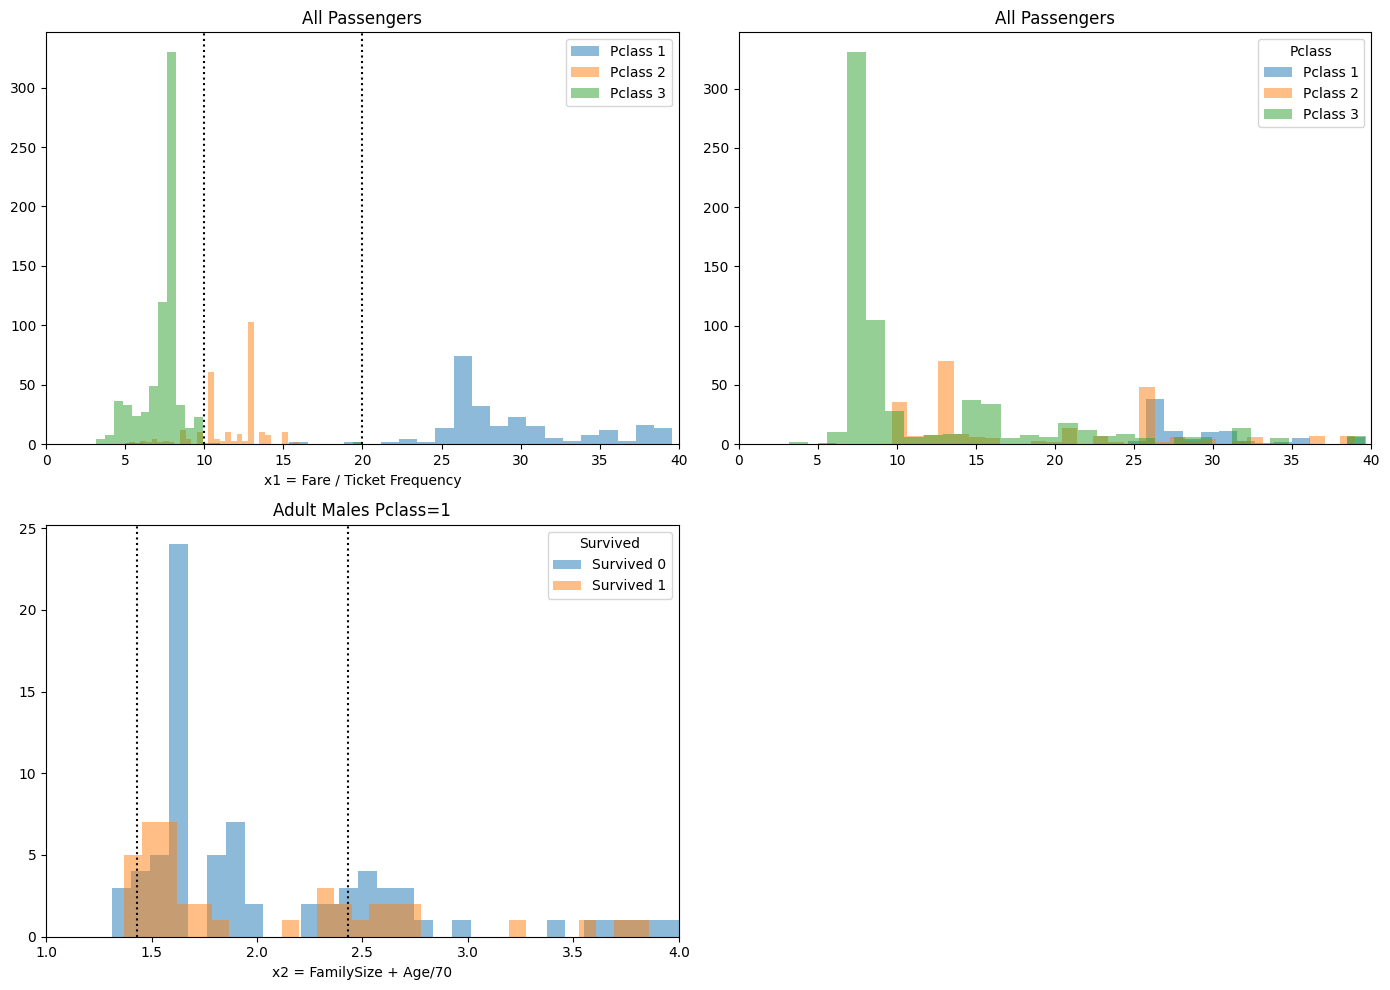

In [21]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Plot 1: FareAdj distribution
for pclass in [1, 2, 3]:
    subset = data[(data['FareAdj'] > 0) & (data['FareAdj'] < 40) & (data['Pclass'] == pclass)]
    axes[0, 0].hist(subset['FareAdj'], alpha=0.5, label=f'Pclass {pclass}', bins=30)
axes[0, 0].axvline(x=10, linestyle='dotted', color='black')
axes[0, 0].axvline(x=20, linestyle='dotted', color='black')
axes[0, 0].set_xlim(0, 40)
axes[0, 0].set_xlabel('x1 = Fare / Ticket Frequency')
axes[0, 0].set_title('All Passengers')
axes[0, 0].legend()

# Plot 2: Fare distribution
for pclass in [1, 2, 3]:
    subset = data[(data['Fare'] > 0) & (data['Fare'] < 40) & (data['Pclass'] == pclass)]
    axes[0, 1].hist(subset['Fare'], alpha=0.5, label=f'Pclass {pclass}', bins=30)
axes[0, 1].set_xlim(0, 40)
axes[0, 1].set_title('All Passengers')
axes[0, 1].legend(title='Pclass')

# Plot 3: FamilySize + Age/70 for adult males
subset = data[
    (~data['Survived'].isna()) & 
    (data['Title'] == 'man') & 
    (data['Pclass'] == 1) & 
    (data['FamilySize'] < 4)
]
for survived in [0, 1]:
    s = subset[subset['Survived'] == survived]
    axes[1, 0].hist(s['FamilySize'] + s['Age']/70, alpha=0.5, label=f'Survived {survived}', bins=30)
axes[1, 0].axvline(x=1.43, linestyle='dotted', color='black')
axes[1, 0].axvline(x=2.43, linestyle='dotted', color='black')
axes[1, 0].set_xlim(1, 4)
axes[1, 0].set_xlabel('x2 = FamilySize + Age/70')
axes[1, 0].set_title('Adult Males Pclass=1')
axes[1, 0].legend(title='Survived')

axes[1, 1].axis('off')
plt.tight_layout()
plt.show()

## Train XGBoost for Men

In [22]:
is_train = data['PassengerId'] <= 891
men_train = is_train & (data['Title'] == 'man') & data['Survived'].notna()

X_men = data.loc[men_train, ['x1', 'x2']].to_numpy()
y_men = data.loc[men_train, 'Survived'].astype(int).to_numpy()

xgb_men = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    n_estimators=500,
    subsample=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_men.fit(X_men, y_men)

print('XGBoost training for men completed')

XGBoost training for men completed


## Predict Men with Threshold >= 0.90

In [23]:
men_test = (data['PassengerId'] > 891) & (data['Title'] == 'man')
X_men_test = data.loc[men_test, ['x1', 'x2']].to_numpy()
p_men = xgb_men.predict_proba(X_men_test)[:, 1]
men_live_pid = data.loc[men_test].assign(p=p_men).query('p >= 0.90')['PassengerId'].tolist()

print(f'Predicted {len(men_live_pid)} adult males to live')
print(men_live_pid)

Predicted 0 adult males to live
[]


## Visualize Men Classification

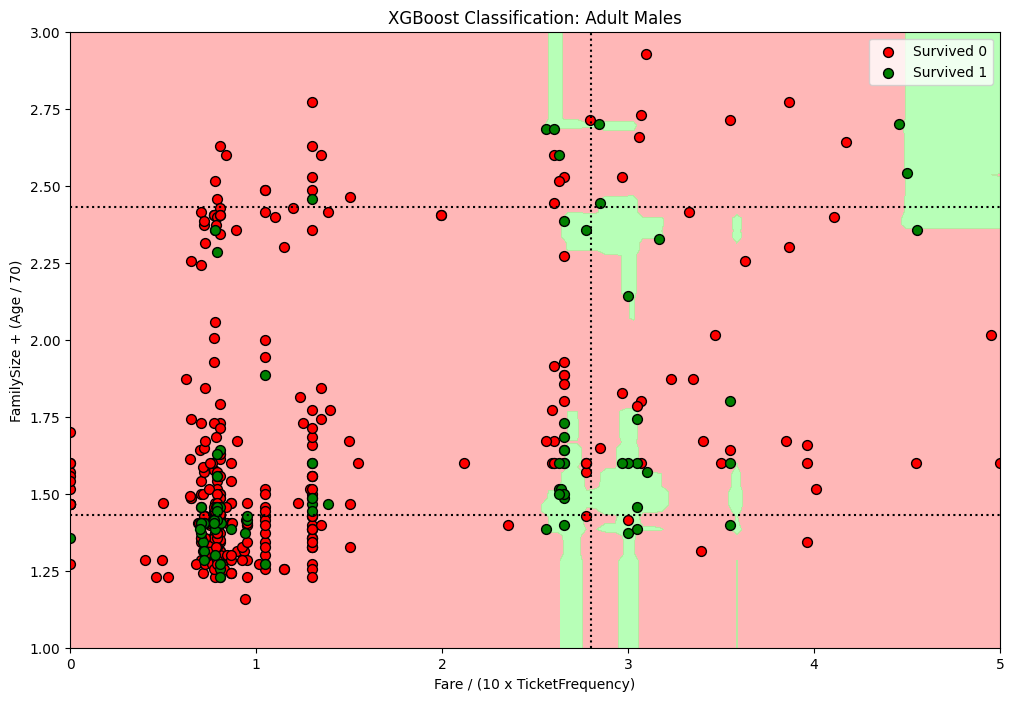

In [24]:
x1s = np.linspace(0, 5, 100)
x2s = np.linspace(1, 3, 100)
X1_grid, X2_grid = np.meshgrid(x1s, x2s)
grid_points = np.c_[X1_grid.ravel(), X2_grid.ravel()]

p_grid = xgb_men.predict_proba(grid_points)[:, 1]
p_grid = p_grid.reshape(X1_grid.shape)

plt.figure(figsize=(12, 8))
plt.contourf(X1_grid, X2_grid, p_grid, levels=[0, 0.5, 1], colors=['#FF9999', '#99FF99'], alpha=0.7)

data_men = data[men_train]
for survived in [0, 1]:
    subset = data_men[data_men['Survived'] == survived]
    plt.scatter(subset['x1'], subset['x2'], c='red' if survived == 0 else 'green', 
                label=f'Survived {survived}', s=50, edgecolors='black')

plt.axvline(x=2.8, linestyle='dotted', color='black')
plt.axhline(y=1.43, linestyle='dotted', color='black')
plt.axhline(y=2.43, linestyle='dotted', color='black')
plt.xlim(0, 5)
plt.ylim(1, 3)
plt.xlabel('Fare / (10 x TicketFrequency)')
plt.ylabel('FamilySize + (Age / 70)')
plt.title('XGBoost Classification: Adult Males')
plt.legend()
plt.show()

In [25]:
# Debug: データの状態を確認
print(f"Total rows in data: {len(data)}")
print(f"Training data rows (PassengerId <= 891): {is_train.sum()}")
print(f"\nTitle distribution in training data:")
print(data[is_train]['Title'].value_counts())
print(f"\nMen in training data: {(is_train & (data['Title'] == 'man')).sum()}")
print(f"Men with non-null Survived: {men_train.sum()}")
print(f"\nChecking data loading:")
print(f"Train file was loaded with {len(train)} rows")
print(f"Test file was loaded with {len(test)} rows")

Total rows in data: 1309
Training data rows (PassengerId <= 891): 891

Title distribution in training data:
Title
man      537
woman    314
boy       40
Name: count, dtype: int64

Men in training data: 537
Men with non-null Survived: 537

Checking data loading:
Train file was loaded with 891 rows
Test file was loaded with 418 rows


## ROC Curve Analysis

X_men sample size: 537
y_men sample size: 537


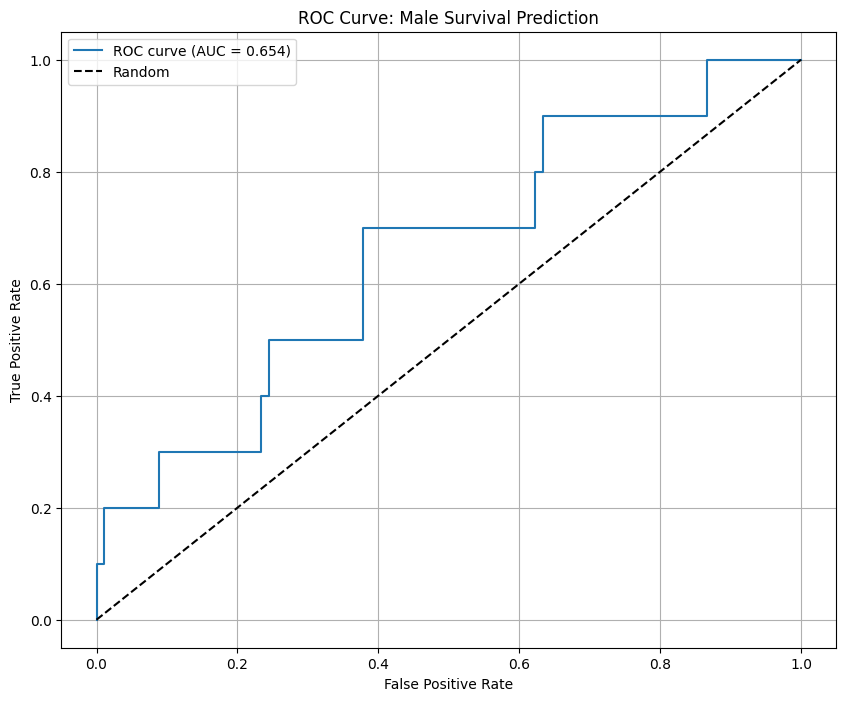

Area under ROC = 0.654444


In [26]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, auc

# X_menのサンプル数を確認
print(f"X_men sample size: {len(X_men)}")
print(f"y_men sample size: {len(y_men)}")

# サンプル数が100より少ない場合は、test_sizeを割合で指定
if len(X_men) > 100:
    test_size = 100
else:
    test_size = 0.2  # 20%をテストデータに

# Split data for ROC
X_train_roc, X_val_roc, y_train_roc, y_val_roc = train_test_split(
    X_men, y_men, test_size=test_size, random_state=RANDOM_STATE
)

xgb_roc = XGBClassifier(
    objective='binary:logistic',
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    n_estimators=500,
    random_state=RANDOM_STATE
)
xgb_roc.fit(X_train_roc, y_train_roc)

p_val = xgb_roc.predict_proba(X_val_roc)[:, 1]
fpr, tpr, thresholds = roc_curve(y_val_roc, p_val)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 8))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], 'k--', label='Random')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve: Male Survival Prediction')
plt.legend()
plt.grid(True)
plt.show()

print(f'Area under ROC = {roc_auc:.6f}')

## Cross-Validation for Men Model

In [ ]:
trials = 100
cv_scores = []

for i in range(trials):
    # Random split
    train_ids = np.random.choice(range(1, 892), 800, replace=False)
    val_ids = [x for x in range(1, 892) if x not in train_ids]
    
        # Filter men
        men_train_cv = data['PassengerId'].isin(train_ids) & (data['Title'] == 'man') & data['Survived'].notna()
        men_val_cv = data['PassengerId'].isin(val_ids) & (data['Title'] == 'man') & data['Survived'].notna()
        
        X_train_cv = data.loc[men_train_cv, ['x1', 'x2']].to_numpy()
        y_train_cv = data.loc[men_train_cv, 'Survived'].astype(int).to_numpy()
        X_val_cv = data.loc[men_val_cv, ['x1', 'x2']].to_numpy()
        y_val_cv = data.loc[men_val_cv, 'Survived'].astype(int).to_numpy()
    
    # Train model
    xgb_cv = XGBClassifier(
        objective='binary:logistic',
        max_depth=5,
        learning_rate=0.1,
        gamma=0.1,
        n_estimators=500,
        random_state=RANDOM_STATE,
        verbosity=0
    )
    xgb_cv.fit(X_train_cv, y_train_cv)
    
    # Predict with threshold 0.90
    p_cv = xgb_cv.predict_proba(X_val_cv)[:, 1]
    pred_cv = (p_cv >= 0.90).astype(int)
    
    # Calculate accuracy on validation set (only men)
    val_pids = data.loc[men_val_cv, 'PassengerId'].values
    data.loc[data['PassengerId'].isin(val_pids), 'Predict_temp'] = pred_cv
    
    # Overall validation accuracy (all passengers in val set)
    val_all = data['PassengerId'].isin(val_ids) & (~data['Survived'].isna())
    y_true_all = data.loc[val_all, 'Survived'].values
    
    # Default prediction: all women survive, all men die
    pred_all = np.where(data.loc[val_all, 'Sex'] == 'female', 1, 0)
    # Override with model predictions for men
    men_idx = data.loc[val_all, 'Title'] == 'man'
    if 'Predict_temp' in data.columns:
        pred_all[men_idx] = data.loc[val_all].loc[data.loc[val_all, 'Title'] == 'man', 'Predict_temp'].fillna(0).values
    
    np.mean(np.abs(pred_all - y_true_all))
    cv_scores.append(accuracy)

print(f'Average CV of {trials} trials = {np.mean(cv_scores):.6f}')

Average CV of 100 trials = 0.787033


## Final Men Predictions

In [28]:
male_live = data[data['PassengerId'].isin(men_live_pid)]
print(f'The following {len(men_live_pid)} adult males are predicted to live:')
print(male_live[['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'FareAdj']])

The following 0 adult males are predicted to live:
Empty DataFrame
Columns: [PassengerId, Pclass, Name, Age, SibSp, Parch, FareAdj]
Index: []


## Engineer Woman-Child-Groups (WCG)

In [29]:
# Extract surname
data['Surname'] = data['Name'].str.split(',').str[0]

# Create GroupId
data['TicketX'] = data['Ticket'].str[:-1] + 'X'
data['GroupId'] = (data['Surname'] + '-' + 
                   data['Pclass'].astype(str) + '-' + 
                   data['TicketX'] + '-' + 
                   data['Fare'].astype(str) + '-' + 
                   data['Embarked'].fillna(''))

# No group for men
data.loc[data['Title'] == 'man', 'GroupId'] = 'noGroup'

# Special case: Mrs Wilkes (893) is Mrs Hocking (775) sister
if 893 in data.index and 775 in data.index:
    data.loc[data['PassengerId'] == 893, 'GroupId'] = data.loc[data['PassengerId'] == 775, 'GroupId'].values[0]

# Calculate group frequency
data['GroupFreq'] = data.groupby('GroupId')['GroupId'].transform('count')
data.loc[data['GroupFreq'] <= 1, 'GroupId'] = 'noGroup'

unique_groups = len(data[data['GroupId'] != 'noGroup']['GroupId'].unique())
print(f'We found {unique_groups} woman-child-groups')

We found 80 woman-child-groups


## Add Nannies and Relatives to Groups

In [30]:
# Create TicketId for matching
data['TicketId'] = (data['Pclass'].astype(str) + '-' + 
                    data['TicketX'] + '-' + 
                    data['Fare'].astype(str) + '-' + 
                    data['Embarked'].fillna(''))

# Add nannies and relatives
count_added = 0
no_group_mask = (data['Title'] != 'man') & (data['GroupId'] == 'noGroup')

for idx in data[no_group_mask].index:
    ticket_id = data.loc[idx, 'TicketId']
    same_ticket = data[data['TicketId'] == ticket_id]
    potential_group = same_ticket[same_ticket['GroupId'] != 'noGroup']['GroupId'].values
    
    if len(potential_group) > 0:
        data.loc[idx, 'GroupId'] = potential_group[0]
        count_added += 1

print(f'We found {count_added} nannies/relatives and added them to groups.')

We found 11 nannies/relatives and added them to groups.


## Calculate Group Survival Rates

In [31]:
# Calculate group survival for training data
train_data = data[data['PassengerId'] <= 891].copy()
group_survival = train_data.groupby('GroupId')['Survived'].mean()

# Map to all data
data['GroupSurvival'] = data['GroupId'].map(group_survival)

# Fill unknowns: Pclass 3 -> 0, others -> 1
data.loc[data['GroupSurvival'].isna() & (data['Pclass'] == 3), 'GroupSurvival'] = 0
data.loc[data['GroupSurvival'].isna() & (data['Pclass'] != 3), 'GroupSurvival'] = 1

## Make Initial Predictions with WCG

In [32]:
data['Predict'] = 0
data.loc[data['Sex'] == 'female', 'Predict'] = 1
data.loc[(data['Title'] == 'woman') & (data['GroupSurvival'] == 0), 'Predict'] = 0
data.loc[(data['Title'] == 'boy') & (data['GroupSurvival'] == 1), 'Predict'] = 1

boys_live = data[(data['Sex'] == 'male') & (data['Predict'] == 1) & (data['PassengerId'] > 891)]
females_die = data[(data['Sex'] == 'female') & (data['Predict'] == 0) & (data['PassengerId'] > 891)]

print(f'We found {len(boys_live)} boys predicted to live')
print(f'We found {len(females_die)} females predicted to die')

We found 8 boys predicted to live
We found 15 females predicted to die


## Create First Submission

In [33]:
submit = pd.DataFrame({
    'PassengerId': data.loc[data['PassengerId'] > 891, 'PassengerId'],
    'Survived': data.loc[data['PassengerId'] > 891, 'Predict']
})

# Add male survivors
for pid in men_live_pid:
    submit.loc[submit['PassengerId'] == pid, 'Survived'] = 1

submit.to_csv('WCG_XGBoost1.csv', index=False)
print('Saved WCG_XGBoost1.csv')

Saved WCG_XGBoost1.csv


## Train XGBoost for Solo Women

In [34]:
solo_w_train = is_train & (data['Title'] == 'woman') & (data['FamilySize'] == 1) & data['Survived'].notna()

X_w = data.loc[solo_w_train].copy()
X_w['x1'] = X_w['FareAdj'] / 10.0
X_w['x2'] = X_w['Age'] / 15.0
X_w_train = X_w[['x1', 'x2']].to_numpy()
y_w = data.loc[solo_w_train, 'Survived'].astype(int).to_numpy()

xgb_w = XGBClassifier(
    objective='binary:logistic',
    eval_metric='logloss',
    max_depth=5,
    learning_rate=0.1,
    gamma=0.1,
    colsample_bytree=1.0,
    min_child_weight=1.0,
    n_estimators=500,
    subsample=1.0,
    random_state=RANDOM_STATE,
    n_jobs=-1,
)
xgb_w.fit(X_w_train, y_w)

print('XGBoost training for solo women completed')

XGBoost training for solo women completed


## Visualize Solo Women Classification

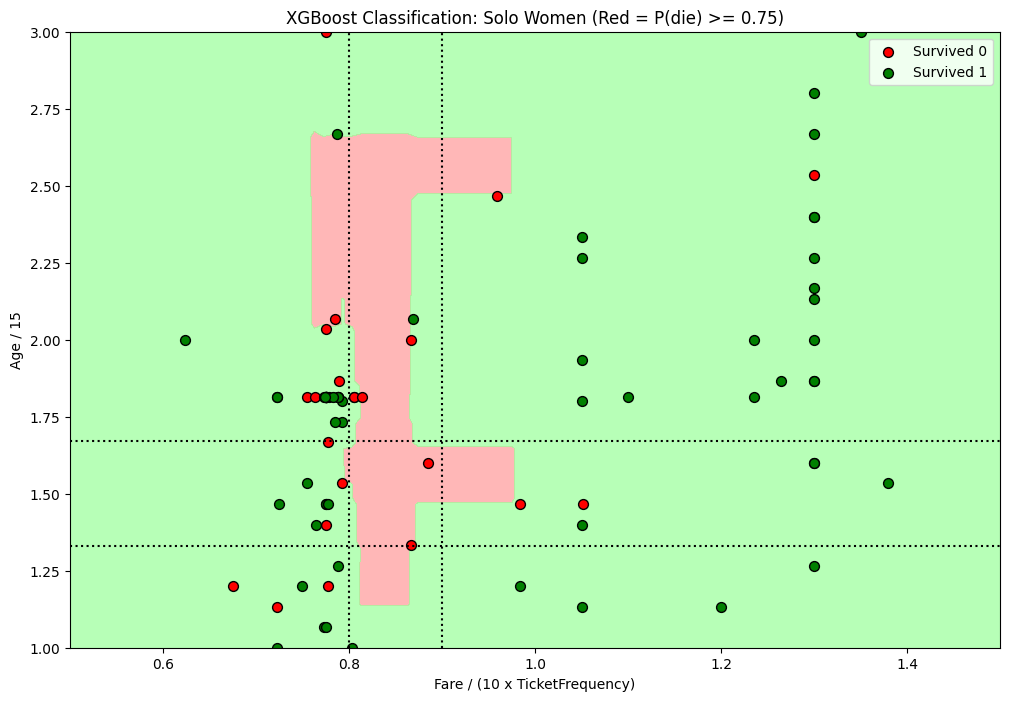

In [35]:
x1s_w = np.linspace(0.5, 1.5, 100)
x2s_w = np.linspace(1, 3, 100)
X1_grid_w, X2_grid_w = np.meshgrid(x1s_w, x2s_w)
grid_points_w = np.c_[X1_grid_w.ravel(), X2_grid_w.ravel()]

p_grid_w = xgb_w.predict_proba(grid_points_w)[:, 1]
p_grid_w = p_grid_w.reshape(X1_grid_w.shape)

plt.figure(figsize=(12, 8))
plt.contourf(X1_grid_w, X2_grid_w, p_grid_w, levels=[0, 0.25, 1], colors=['#FF9999', '#99FF99'], alpha=0.7)

data_w = data[solo_w_train]
for survived in [0, 1]:
    subset = data_w[data_w['Survived'] == survived]
    plt.scatter(subset['FareAdj']/10, subset['Age']/15, c='red' if survived == 0 else 'green', 
                label=f'Survived {survived}', s=50, edgecolors='black')

plt.axvline(x=0.8, linestyle='dotted', color='black')
plt.axvline(x=0.9, linestyle='dotted', color='black')
plt.axhline(y=1.33, linestyle='dotted', color='black')
plt.axhline(y=1.67, linestyle='dotted', color='black')
plt.xlim(0.5, 1.5)
plt.ylim(1, 3)
plt.xlabel('Fare / (10 x TicketFrequency)')
plt.ylabel('Age / 15')
plt.title('XGBoost Classification: Solo Women (Red = P(die) >= 0.75)')
plt.legend()
plt.show()

## Cross-Validation for Solo Women Model

In [40]:
trials = 100
cv_scores_w = []

for i in range(trials):
    train_ids = np.random.choice(range(1, 892), 800, replace=False)
    val_ids = [x for x in range(1, 892) if x not in train_ids]
    
    w_train_cv = (data['PassengerId'].isin(train_ids) & 
                  (data['Title'] == 'woman') & 
                  (data['FamilySize'] == 1) & 
                  data['Survived'].notna())
    w_val_cv = (data['PassengerId'].isin(val_ids) & 
                (data['Title'] == 'woman') & 
                (data['FamilySize'] == 1) & 
                data['Survived'].notna())
    
    X_w_cv = data.loc[w_train_cv].copy()
    X_w_cv['x1'] = X_w_cv['FareAdj'] / 10.0
    X_w_cv['x2'] = X_w_cv['Age'] / 15.0
    X_train_w_cv = X_w_cv[['x1', 'x2']].to_numpy()
    y_train_w_cv = data.loc[w_train_cv, 'Survived'].astype(int).to_numpy()
    
    X_w_val_cv = data.loc[w_val_cv].copy()
    X_w_val_cv['x1'] = X_w_val_cv['FareAdj'] / 10.0
    X_w_val_cv['x2'] = X_w_val_cv['Age'] / 15.0
    X_val_w_cv = X_w_val_cv[['x1', 'x2']].to_numpy()
    y_val_w_cv = data.loc[w_val_cv, 'Survived'].astype(int).to_numpy()
    
    xgb_w_cv = XGBClassifier(
        objective='binary:logistic',
        max_depth=5,
        learning_rate=0.1,
        gamma=0.1,
        n_estimators=500,
        random_state=RANDOM_STATE,
        verbosity=0
    )
    xgb_w_cv.fit(X_train_w_cv, y_train_w_cv)
    
    p_w_cv = xgb_w_cv.predict_proba(X_val_w_cv)[:, 1]
    pred_w_cv = (p_w_cv > 0.08).astype(int)
    
    # Overall accuracy on validation set
    val_all = data['PassengerId'].isin(val_ids) & (~data['Survived'].isna())
    pred_all = np.where(data.loc[val_all, 'Sex'] == 'female', 1, 0)
    
    accuracy = 1 - np.mean(np.abs(pred_all - data.loc[val_all, 'Survived'].values))
    cv_scores_w.append(accuracy)

print(f'Average CV of {trials} trials = {np.mean(cv_scores_w):.6f}')
print(f'Average CV of {trials} trials = {np.mean(cv_scores_w):.6f}')
print(f'Standard deviation = {np.std(cv_scores_w):.6f}')
print(f'Min score = {np.min(cv_scores_w):.6f}')
print(f'Max score = {np.max(cv_scores_w):.6f}')

Average CV of 100 trials = 0.793077
Average CV of 100 trials = 0.793077
Standard deviation = 0.036942
Min score = 0.714286
Max score = 0.890110


## Final Solo Women Predictions

In [37]:
# Identify WCG test passengers
WCG_test = (data['PassengerId'] > 891) & ((data['GroupSurvival'] == 0) | (data['GroupSurvival'] == 1))
WCG_test_pids = data.loc[WCG_test, 'PassengerId'].values

# Solo women test set (excluding WCG)
solo_w_test = ((data['PassengerId'] > 891) & 
               (data['Title'] == 'woman') & 
               (data['FamilySize'] == 1) & 
               (~data['PassengerId'].isin(WCG_test_pids)))

if solo_w_test.sum() > 0:
    Xw_test = data.loc[solo_w_test].copy()
    Xw_test['x1'] = Xw_test['FareAdj'] / 10.0
    Xw_test['x2'] = Xw_test['Age'] / 15.0
    Xw_test_arr = Xw_test[['x1', 'x2']].to_numpy()
    
    p_w = xgb_w.predict_proba(Xw_test_arr)[:, 1]
    solo_w_pid = data.loc[solo_w_test, 'PassengerId'].to_list()
    
    # Threshold p <= 0.08 for death
    female_perish_pid = [pid for pid, p in zip(solo_w_pid, p_w) if p <= 0.08]
    
    print(f'The following {len(female_perish_pid)} females are predicted to die:')
    female_perish_data = data[data['PassengerId'].isin(female_perish_pid)]
    print(female_perish_data[['PassengerId', 'Pclass', 'Name', 'Age', 'SibSp', 'Parch', 'FareAdj']])
else:
    female_perish_pid = []
    print('No solo women found in test set')

The following 1 females are predicted to die:
      PassengerId  Pclass                   Name   Age  SibSp  Parch  FareAdj
1029         1030       3  Drapkin, Miss. Jennie  23.0      0      0     8.05


## Create Second Submission

In [38]:
for pid in female_perish_pid:
    submit.loc[submit['PassengerId'] == pid, 'Survived'] = 0

submit.to_csv('WCG_XGBoost2.csv', index=False)
print('Saved WCG_XGBoost2.csv')

Saved WCG_XGBoost2.csv


## Summary

In [39]:
print('='*50)
print('FINAL PREDICTIONS SUMMARY')
print('='*50)
print(f'Adult males predicted to live (p >= 0.90): {len(men_live_pid)}')
print(f'Solo females predicted to die (p <= 0.08): {len(female_perish_pid)}')
print(f'Total survival predictions: {submit["Survived"].sum()}')
print(f'Total death predictions: {len(submit) - submit["Survived"].sum()}')

FINAL PREDICTIONS SUMMARY
Adult males predicted to live (p >= 0.90): 0
Solo females predicted to die (p <= 0.08): 1
Total survival predictions: 144
Total death predictions: 274
